In [38]:
import glob,os,sys,numpy as np, matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from scipy import signal
from scipy.optimize import differential_evolution
import warnings
import astropy.io.fits as fits
import pandas as pd
import cartopy.crs as ccrs
from matplotlib import gridspec
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize, interpolate, ndimage, stats
from scipy.optimize import OptimizeWarning

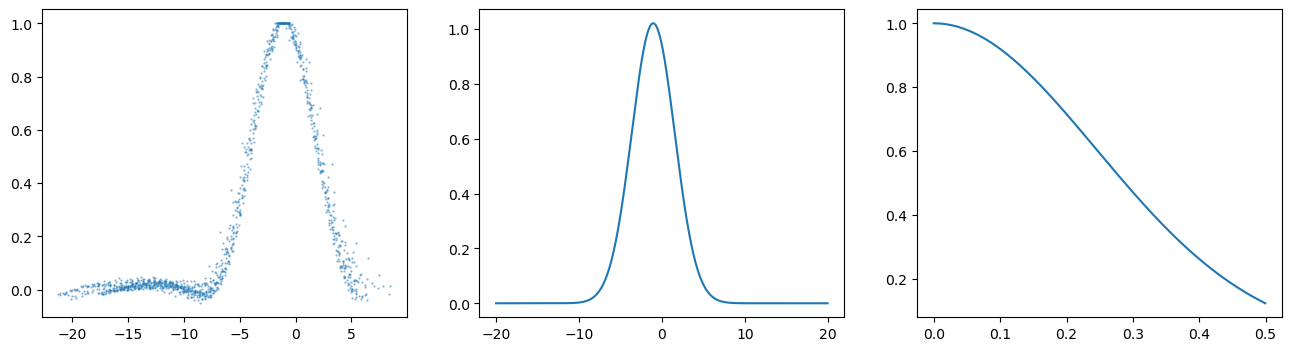

In [34]:

path = '/home/sarah/Desktop/Landsat_sandbox/sahara_206045_alongcoast/'
dlsf = pd.read_csv(path+'LC08_206045_20220102_datLSF.csv') #header=0, index_col=0, parse_dates=True

flsf = pd.read_csv(path+'LC08_206045_20220102_fitLSF.csv')

mtf = pd.read_csv(path+'LC08_206045_20220102_myMTF.csv')

fig ,(ax1,ax2,ax3) =  plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(dlsf['psfx'],dlsf['psfy'],ls='',marker = '.',markersize = 1.2,alpha= 0.5)
ax2.plot(flsf['xgaus'],flsf['ygaus'])
ax3.plot(mtf.mtfFreq[mtf.mtfFreq<0.5], mtf.mtfVsFreq[mtf.mtfFreq<0.5])


In [2]:
def getMTF(lsf):
    # NOTE: LSF input has to be 2D array with first column being the pixels and second column the LSF values

    summary = ""
    print("shape lsf", lsf.shape)
    
    # If needed, remove the last element of the PSF to get an even number of elements         

    if lsf.shape[1]/2. != lsf.shape[1]//2.:
        print('needed!')
        lsf = lsf[:,:-1]

    pixrange = np.max(lsf[0])-np.min(lsf[0])
        
    lsf = lsf[1]

    n = lsf.shape[0]
    lsf = np.append(
            np.append(
                np.zeros([20*n]), 
                lsf),
            np.zeros([20*n])
        )
    
    lsf = lsf/np.sum(lsf)
    
    N = len(lsf)
    print("Length lsf",N)
    
    mtf = np.fft.rfft(lsf)

    sampFreq = 1./100#30
    nyquistFreq = sampFreq/2.
    adjustedSampFreq = sampFreq*pixrange/N

    print('Imaging sample freq= ',sampFreq)
    print('LSF sampling rate= ',adjustedSampFreq)

    mtfFreq = np.linspace(0, (N/2)*adjustedSampFreq/nyquistFreq, num=mtf.shape[0], dtype=np.float64)
    mtfVsFreq = interpolate.interp1d(mtfFreq, np.absolute(mtf), kind='linear')
    freqVsMtf = interpolate.interp1d(np.absolute(mtf), mtfFreq, kind='linear')
    mtfNy = mtfVsFreq(0.5)
    # ResultsStr += "MTF0: %s \n" % mtf[0]
    # summary += "FWHM = %f "% np.round(gfwhm,4)
    # summary += "+/- %f \n" % np.round(gfwhmerr,4)
    # summary += "\n"
    # summary += "Edge Slope = %f "% np.round(gs,4)
    # summary += "+/- %f \n" % np.round(sloperr,4)
    # summary += "\n"
    # summary += "30percent MTF = %f \n" % freqVsMtf(0.3)
    # summary += "\n"
    # summary += "50percent MTF = %f \n" % freqVsMtf(0.5)
    # summary += "\n"
    # summary += "MTF@f_Ny =  %f \n" % mtfVsFreq(0.5)
    # print("\n############ Results\n"+summary+"####################\n")
    
    return mtf, mtfFreq, mtfVsFreq, summary, nyquistFreq, mtfNy


shape lsf (1216, 1216)
Length lsf 49856
Imaging sample freq=  0.01
LSF sampling rate=  5.94534263680856e-06


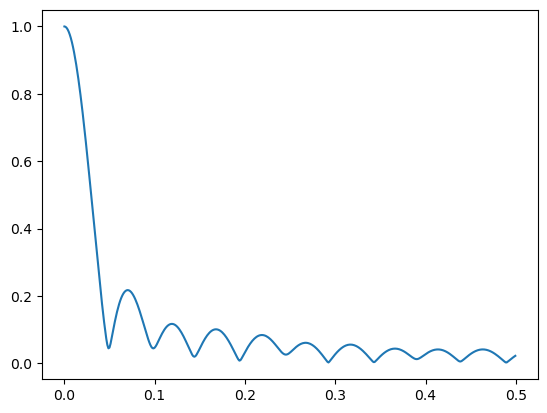

In [40]:
lsf = np.zeros((len(dlsf['psfx']),len(dlsf['psfy'])))
lsf[0,:]= dlsf['psfx'] #xgaus
lsf[1,:]=dlsf['psfy']  #ygaus

    
mtf, mtfFreq, mtfVsFreq, summary, nyquistFreq, mtfNy  = getMTF(lsf)

plt.plot(mtfFreq[mtfFreq<0.5],mtfVsFreq(mtfFreq[mtfFreq<0.5]) )
